In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


import matplotlib.pyplot as plt

Hyperparameters

In [2]:
input_size = 2  # Number of input features
hidden_size = 50  # Number of LSTM units
output_size = 1  # Number of output features
num_layers = 2  # Number of LSTM layers

num_epochs = 500
learning_rate = 0.001
sequence_length = 10
batch_size = 32
dropout= 0.3
weight_decay = 1e-5  # Adjust this value

#dataset control
left_only=False
no_negative = False
max_length_on = True
max_length = 30

Dataset

In [3]:
def create_sequences(x, y, seq_length):
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    x = torch.mul(x,1)
    y = torch.mul(y,1)
    sequences = []
    labels = []

    for i in range(len(x) - seq_length):
        if left_only and x[i+seq_length][2] != -1: # if direction != left
            continue
        if no_negative and x[i+seq_length][0] < 0: # if past goal
            continue
        if max_length_on and x[i+seq_length][3] >= max_length: # 30 frames from crossing goal
            continue

        seq = x[i:i+seq_length]
        seq = seq[:,[0,1]] # Puck_cen_X, Puck_cen_Y
        label = y[i+seq_length]
        sequences.append(seq)
        labels.append(label)

    return torch.stack(sequences), torch.stack(labels)


Data Loader

In [4]:
class CustomDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [5]:
#df = pd.read_csv("Data/cleaned_data.csv")
df = pd.read_csv("Data/Combined_numerated.csv")

X = df[["Puck_cen_X","Puck_cen_Y","direction", "Count"]].values # values between 2 and -1
Y = df[["Cross_Left"]].values
#Y = df["Cross_right"].values

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, shuffle=False)
X_test, X_train, y_test, y_train = train_test_split(X, Y, test_size=0.6, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

train_sequences, train_labels = create_sequences(X_train, y_train, sequence_length)
val_sequences, val_labels = create_sequences(X_val, y_val, sequence_length)
test_sequences, test_labels = create_sequences(X_test, y_test, sequence_length)

In [6]:
train_dataset = CustomDataset(train_sequences, train_labels)
val_dataset = CustomDataset(val_sequences, val_labels)
test_dataset = CustomDataset(test_sequences, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
print("train:",train_sequences.shape)
print("val",val_sequences.shape)
print("test",test_sequences.shape)

train: torch.Size([9723, 10, 2])
val torch.Size([2460, 10, 2])
test torch.Size([3018, 10, 2])


In [8]:
del X, Y, X_train, X_test, X_val, y_train, y_test, y_val # deleate
del train_sequences, val_sequences

Physics Model

In [9]:
def physics_prediction(test_seq):
    yc = np.zeros(test_seq.shape[0])
    for i in range(1,test_seq.shape[0]):
        dx = test_seq[i,-1,0] - test_seq[i,-2,0]
        dy = test_seq[i,-1,1] - test_seq[i,-2,1]
        x=test_seq[i,-1,0]
        y=test_seq[i,-1,1]
        xc=1

        if dx >-0.0001: #slow or wrong way
            yc[i]=0.5
            continue

        while(xc>0):
            if dy >0: #moving upwards
                #1=dy*t + y
                #t =(1-y)/dy
                xc = dx*(1-y)/dy + x
                if xc > 0:
                    x=xc # reset x to the impact point
                    y=1
                    dy = -dy #same angle, opposit direction
                    #print("hit top at:", xc)

            elif dy<0:
                #0=dy*t+y
                #t=(-y/dy)
                xc = dx*(-y)/dy + x
                if xc > 0:
                    x=xc # reset x to the impact point
                    y=0
                    dy = -dy #same angle, opposit direction
                    #print("hit bottom at:", xc)
            
            else:
                break

        #0=dx*t+x
        #t=-x/dx
        yc[i] = dy*(-x/dx) + y
    
    return yc


In [10]:
phys_pred = physics_prediction(test_sequences)
phys_pred_t = torch.from_numpy(phys_pred)
criterion = nn.MSELoss()
physics_loss = criterion(phys_pred_t, test_labels)



c:\Other_Programs\anaconda3\envs\RL_Project\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([3018, 1])) that is different to the input size (torch.Size([3018])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LSTM Model

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout =dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

Criterion

In [12]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

cuda


Training

In [13]:
train_loss =np.zeros(num_epochs)
val_loss=np.zeros(num_epochs)

In [14]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for batch_sequences, batch_labels in train_loader:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
        
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_labels)
        train_loss[epoch] += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for val_sequences, val_labels in val_loader:
            
            val_sequences, val_labels = val_sequences.to(device), val_labels.to(device)
            
            outputs_val = model(val_sequences)
            loss_val = criterion(outputs_val, val_labels)
            val_loss[epoch] += loss_val.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss[epoch]/len(train_loader):.4f}, Validation Loss: {val_loss[epoch]/len(val_loader):.4f}')


Epoch [10/500], Training Loss: 0.0742, Validation Loss: 0.0874
Epoch [20/500], Training Loss: 0.0739, Validation Loss: 0.0859
Epoch [30/500], Training Loss: 0.0737, Validation Loss: 0.0853
Epoch [40/500], Training Loss: 0.0731, Validation Loss: 0.0843
Epoch [50/500], Training Loss: 0.0727, Validation Loss: 0.0847
Epoch [60/500], Training Loss: 0.0725, Validation Loss: 0.0858
Epoch [70/500], Training Loss: 0.0719, Validation Loss: 0.0847
Epoch [80/500], Training Loss: 0.0701, Validation Loss: 0.0824
Epoch [90/500], Training Loss: 0.0670, Validation Loss: 0.0771
Epoch [100/500], Training Loss: 0.0639, Validation Loss: 0.0746
Epoch [110/500], Training Loss: 0.0611, Validation Loss: 0.0768
Epoch [120/500], Training Loss: 0.0582, Validation Loss: 0.0757
Epoch [130/500], Training Loss: 0.0557, Validation Loss: 0.0792
Epoch [140/500], Training Loss: 0.0525, Validation Loss: 0.0764
Epoch [150/500], Training Loss: 0.0496, Validation Loss: 0.0800
Epoch [160/500], Training Loss: 0.0474, Validatio

<function matplotlib.pyplot.show(close=None, block=None)>

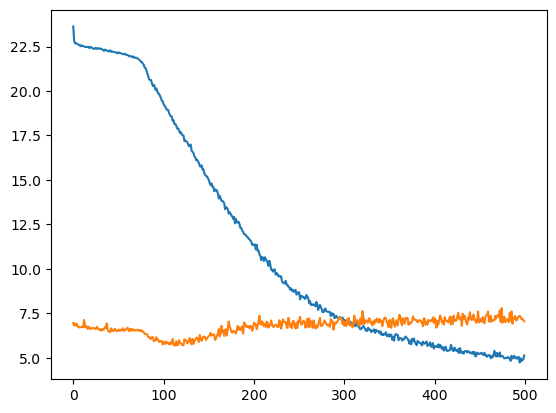

In [15]:
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = "val loss")
plt.legend
plt.show

Testing

In [16]:
# Testing
model.eval()
test_loss = 0.0
mseLoss = nn.MSELoss()
maeLoss = nn.L1Loss()
with torch.no_grad():
    for testing_sequences, testing_labels in test_loader:
        testing_sequences, testing_labels= testing_sequences.to(device), testing_labels.to(device)
        test_outputs = model(testing_sequences)
        test_loss += mseLoss(test_outputs, testing_labels).item()

print(f'Mean Square Error on Test Data: {test_loss/len(test_loader):.4f}')


Mean Square Error on Test Data: 0.1155


In [17]:
#testing
model.eval()
mseLoss = nn.MSELoss()
maeLoss = nn.L1Loss()
with torch.no_grad():
    test_sequences_GPU = test_sequences.to(device)
    test_outputs = model(test_sequences_GPU)
    test_labels_GPU = test_labels.to(device)
    mse = mseLoss(test_outputs, test_labels_GPU)
    mae = maeLoss(test_outputs, test_labels_GPU)
    print(f'Mean Square Error on physics model: {physics_loss.item():.4f}')
    print(f'Mean Square Error on Test Data: {mse.item():.4f}')
    print(f'Mean Absolute Error on Test Data: {mae.item():.4f}')

Mean Square Error on physics model: 0.1622
Mean Square Error on Test Data: 0.1160
Mean Absolute Error on Test Data: 0.2699


Visualization

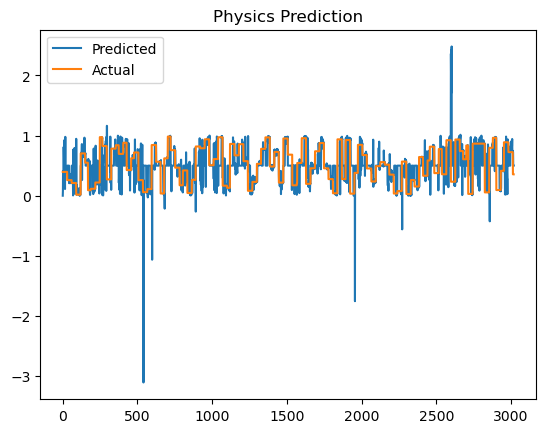

In [18]:
plt.plot(phys_pred, label='Predicted')
plt.plot(test_labels.numpy(), label='Actual')
plt.title("Physics Prediction")
plt.legend()
plt.show()

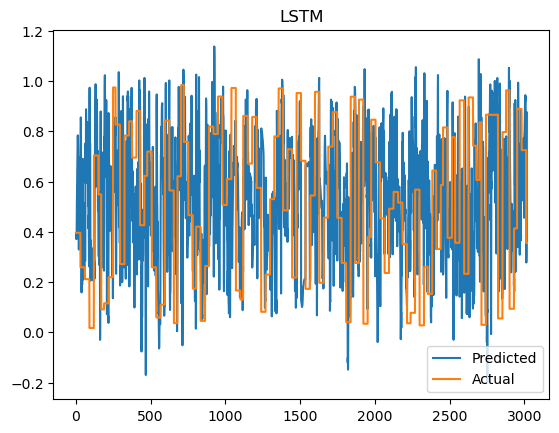

In [19]:
plt.plot(test_outputs.cpu().numpy(), label='Predicted')
plt.plot(test_labels.numpy(), label='Actual')
plt.title("LSTM")
plt.legend()
plt.show()

In [20]:
print(test_outputs.shape)
print(test_labels.shape)

torch.Size([3018, 1])
torch.Size([3018, 1])


In [21]:
physics_misses = 0
LSTM_misses = 0
total_shots = 0
test_outputs = test_outputs.cpu()
for i in range(test_labels.shape[0]-1):
    if test_labels[i]!=test_labels[i+1]:
        total_shots+=1
        if abs(phys_pred_t[i]-test_labels[i]) >0.1:
            physics_misses +=1
        if abs(test_outputs[i]-test_labels[i]) >0.1:
            LSTM_misses+=1

print("total shots", total_shots)
print("physics misses:",physics_misses)
print("LSTM_misses:", LSTM_misses)

total shots 109
physics misses: 8
LSTM_misses: 50
